In [1]:
import os
import math
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
from torch.nn import functional as F
from tqdm.auto import tqdm
from models import MultiLayeredPerceptron
from lora_models import LoRAModel
from flattened_datasets import MNIST, FashionMNIST
import project_paths as pp
from IPython.display import display, HTML, Markdown, clear_output
from sklearn.metrics import confusion_matrix as cm, precision_recall_fscore_support
from matplotlib import pyplot as plt

# Testing (prior to full fine-tuning)
Taking the pre-trained model on MNIST and checking it's performance on FashionMNIST

## Defining hyper-parameters for testing

In [2]:
test_batch_size = 100

## Loading & preparing dataset

In [3]:
test_dataset = FashionMNIST(train=False)
num_instances_in_test_dataset = len(test_dataset)

num_test_batches = math.ceil(len(test_dataset) / test_batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size)

## Loading & preparing model for testing

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
pre_trained_model = MultiLayeredPerceptron()
pre_trained_model_folder_path = os.path.join(pp.models_folder_path, 'mlp', 'flattened_MNIST', 'pre_trained', 'least_val_loss.pt')
pre_trained_model.load_state_dict(torch.load(pre_trained_model_folder_path, weights_only=True))
pre_trained_model.to(device)
pre_trained_model.eval()

MultiLayeredPerceptron(
  (linear_0): Linear(in_features=784, out_features=512, bias=True)
  (dropout_0): Dropout(p=0.2, inplace=False)
  (relu_0): ReLU(inplace=True)
  (linear_1): Linear(in_features=512, out_features=512, bias=True)
  (dropout_1): Dropout(p=0.2, inplace=False)
  (relu_1): ReLU(inplace=True)
  (linear_2): Linear(in_features=512, out_features=512, bias=True)
  (dropout_2): Dropout(p=0.2, inplace=False)
  (relu_2): ReLU(inplace=True)
  (output): Linear(in_features=512, out_features=10, bias=True)
)

## Predicting

In [6]:
actual_labels = []
predicted_scores = []
predicted_labels = []

test_dataset_evaluation_progress_bar = tqdm(total=num_test_batches, desc='Evaluating', dynamic_ncols=False)
for batch in test_dataloader:
    images, targets = batch
    images = images.to(device)
    targets = targets.to(device)
    
    batch_actual_labels = torch.argmax(targets, dim=-1)
    actual_labels += batch_actual_labels.cpu().detach().numpy().tolist()

    predictions = pre_trained_model(images)
    batch_predicted_scores = F.softmax(predictions, dim=-1)
    batch_predicted_labels = torch.argmax(batch_predicted_scores, dim=-1)
    predicted_scores += batch_predicted_scores.cpu().detach().numpy().tolist()
    predicted_labels += batch_predicted_labels.cpu().detach().numpy().tolist()

    test_dataset_evaluation_progress_bar.update(1)

test_dataset_evaluation_progress_bar.close()
clear_output()

## Computing metrics

In [7]:
accuracy = 0
for actual_label, predicted_label in zip(actual_labels, predicted_labels):
    if actual_label == predicted_label:
        accuracy += 1
accuracy /= len(test_dataset)
print(f'Accuracy: {accuracy}')

Accuracy: 0.0683


In [8]:
precision, recall, f1, support = precision_recall_fscore_support(actual_labels, predicted_labels, labels=list(range(10)), average=None)
metrics_table = {
    'label': [],
    'precision': [],
    'recall': [],
    'f1': []
}
for label_idx, (precision_value, recall_value, f1_value) in enumerate(zip(precision, recall, f1)):
    metrics_table['label'].append(FashionMNIST.LABEL_MAP[label_idx])
    metrics_table['precision'].append(precision_value)
    metrics_table['recall'].append(recall_value)
    metrics_table['f1'].append(f1_value)

metrics_table = pd.DataFrame.from_dict(metrics_table).set_index('label')
average_precision = metrics_table['precision'].mean()
average_recall = metrics_table['recall'].mean()
average_f1 = metrics_table['f1'].mean()
display(
    Markdown(
        f'* Average precision: {round(average_precision, 5)}' + '\n' + \
        f'* Average recall: {round(average_recall, 5)}' + '\n' + \
        f'* Average f1: {round(average_f1, 5)}'
    )
)
display(metrics_table)

* Average precision: 0.16364
* Average recall: 0.0683
* Average f1: 0.04834

,precision,recall,f1
label,,,
T-Shirt,0.042991,0.023,0.029967
Trouser,0.333333,0.001,0.001994
Pullover,0.023386,0.092,0.037292
Dress,0.441176,0.045,0.081670
Coat,0.043956,0.004,0.007333
Sandal,0.578947,0.055,0.100457
Shirt,0.134868,0.451,0.207643
Sneaker,0.033195,0.008,0.012893
Bag,0.001767,0.001,0.001277


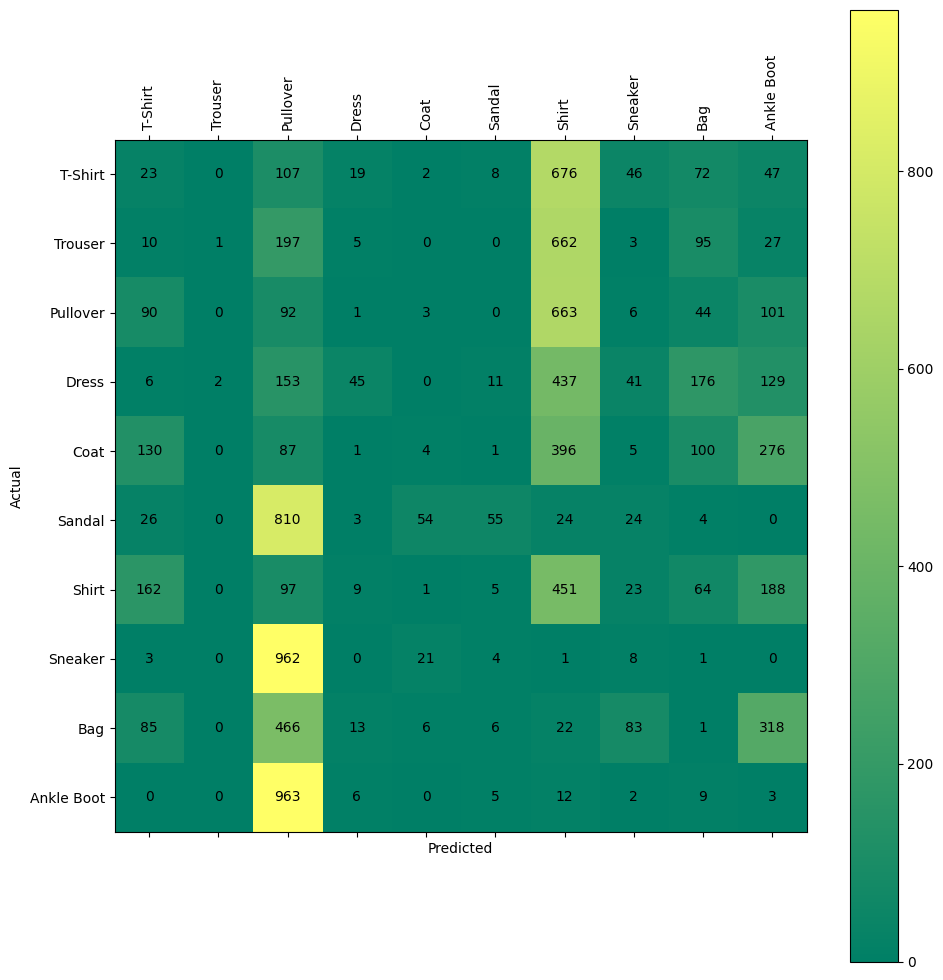

In [9]:
confusion_matrix = cm(actual_labels, predicted_labels)

plt.figure(num='Confusion Matrix', figsize=(10, 10))
plt.matshow(confusion_matrix, cmap='summer', fignum=0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(list(range(10)), [FashionMNIST.LABEL_MAP[label_idx] for label_idx in range(10)], rotation=90)
plt.yticks(list(range(10)), [FashionMNIST.LABEL_MAP[label_idx] for label_idx in range(10)])
for (i, j), value in np.ndenumerate(confusion_matrix):
    plt.text(j, i, value, ha='center', va='center')
plt.colorbar()
plt.tight_layout()
plt.show()

# LoRA Fine-tuning

## Defining hyper-parameters for LoRA fine-tuning

In [10]:
num_epochs = 20
train_batch_size = 64
val_batch_size = 64
learning_rate = 5e-4
betas = (0.9, 0.98)

## Loading & preparing datasets

In [11]:
dataset = FashionMNIST(train=True)

train_dataset_frac = 0.8
num_instances_in_train_dataset = int(len(dataset) * train_dataset_frac)
num_instances_in_val_dataset = len(dataset) - num_instances_in_train_dataset
train_dataset, val_dataset = random_split(
    dataset,
    [num_instances_in_train_dataset, num_instances_in_val_dataset],
    generator=torch.Generator().manual_seed(1618)
)

num_train_batches = math.ceil(len(train_dataset) / train_batch_size)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

num_val_batches = math.ceil(len(val_dataset) / val_batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=True)

## Loading model and preparing it for training

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
torch.manual_seed(0)

In [14]:
pre_trained_model = MultiLayeredPerceptron()
pre_trained_model_folder_path = os.path.join(pp.models_folder_path, 'mlp', 'flattened_MNIST', 'pre_trained', 'least_val_loss.pt')
pre_trained_model.load_state_dict(torch.load(pre_trained_model_folder_path, weights_only=True))

lora_config = {
    'linear_*': {
        'alpha': 12,
        'rank': 8,
        'delta_bias': True,
        'beta': 2
    },
    'output': {
        'alpha': 12,
        'rank': 8,
        'delta_bias': True,
        'beta': 2
    }
}
lora_model = LoRAModel(pre_trained_model, lora_config)
lora_model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(lora_model.parameters(), lr=learning_rate, betas=betas)

In [15]:
total_parameters = 0
num_trainable_parameters = 0
num_non_trainable_parameters = 0
for parameter in lora_model.parameters():
    num_parameters = parameter.numel()
    total_parameters += num_parameters
    if parameter.requires_grad:
        num_trainable_parameters += num_parameters
    else:
        num_non_trainable_parameters += num_parameters

print(f'Total parameters: {total_parameters}')
print(f'Total trainable parameters: {num_trainable_parameters}')
print(f'Total non-trainable parameters: {num_non_trainable_parameters}')

Total parameters: 964836
Total trainable parameters: 32474
Total non-trainable parameters: 932362


In [16]:
models_output_folder_path = os.path.join(pp.models_folder_path, 'mlp', 'flattened_FashionMNIST', 'lora_fine_tuned_with_b')
if not os.path.isdir(models_output_folder_path):
    os.makedirs(models_output_folder_path)

## Training

In [17]:
lora_model.enable_adapter()

In [18]:
training_summary = {
    'epoch_number': [],
    'train_loss': [],
    'val_loss': []
}

min_epoch_val_loss = float('inf')

for epoch_idx in range(num_epochs):
    clear_output()
    display(Markdown('**Training Summary**'))
    display(pd.DataFrame.from_dict(training_summary).set_index('epoch_number'))

    training_summary['epoch_number'].append(epoch_idx + 1)
    
    epoch_train_progress_bar = tqdm(total=num_train_batches, desc=f'Training epoch {epoch_idx + 1} of {num_epochs}: ', dynamic_ncols=True)
    lora_model.train()
    epoch_train_loss = 0
    for batch in train_dataloader:
        batch_size = len(batch)
        flattened_images, targets = batch
        flattened_images = flattened_images.to(device)
        targets = targets.to(device)

        predicted = lora_model(flattened_images)
        
        batch_train_loss = loss_function(predicted, targets)
        epoch_train_loss += batch_train_loss.item()
        batch_train_loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        
        epoch_train_progress_bar.update(1)
    epoch_train_progress_bar.close()
    training_summary['train_loss'].append(epoch_train_loss)

    epoch_val_progress_bar = tqdm(total=num_val_batches, desc=f'Evaluating epoch {epoch_idx + 1} of {num_epochs}: ', dynamic_ncols=True)
    lora_model.eval()
    epoch_val_loss = 0
    for batch in val_dataloader:
        batch_size = len(batch)
        flattened_images, targets = batch
        flattened_images = flattened_images.to(device)
        targets = targets.to(device)
        
        predicted = lora_model(flattened_images)
        
        batch_val_loss = loss_function(predicted, targets)
        epoch_val_loss += batch_val_loss.item()

        epoch_val_progress_bar.update(1)
    epoch_val_progress_bar.close()
    training_summary['val_loss'].append(epoch_val_loss)

    torch.save(lora_model.get_merged_model().state_dict(), os.path.join(models_output_folder_path, f'epoch_{str(epoch_idx + 1).zfill(2)}.pt'))
    if epoch_val_loss < min_epoch_val_loss:
        torch.save(lora_model.get_merged_model().state_dict(), os.path.join(models_output_folder_path, 'least_val_loss.pt'))

clear_output()
training_summary = pd.DataFrame.from_dict(training_summary).set_index('epoch_number')
training_summary.to_csv(os.path.join(models_output_folder_path, 'training_summary.csv'), index=True)
display(Markdown('**Training Summary**'))
display(training_summary)

**Training Summary**

,train_loss,val_loss
epoch_number,,
1,3253.909361,111.210741
2,463.539379,86.217926
3,373.527680,75.161154
4,337.382154,71.996971
5,315.594934,71.039934
6,300.013348,66.460298
7,289.220889,66.303829
8,278.967857,64.133722
9,269.443552,63.592758


In [19]:
lora_model.disable_adapter()

# Testing (post LoRA fine-tuning)

## Defining hyper-parameters for testing

In [20]:
test_batch_size = 100

## Loading & preparing dataset

In [21]:
test_dataset = FashionMNIST(train=False)
num_instances_in_test_dataset = len(test_dataset)

num_test_batches = math.ceil(len(test_dataset) / test_batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size)

## Loading & preparing model for testing

In [22]:
fine_tuned_model = MultiLayeredPerceptron()
fine_tuned_model.load_state_dict(torch.load(os.path.join(models_output_folder_path, 'least_val_loss.pt'), weights_only=True))
fine_tuned_model.to(device)
fine_tuned_model.eval()

MultiLayeredPerceptron(
  (linear_0): Linear(in_features=784, out_features=512, bias=True)
  (dropout_0): Dropout(p=0.2, inplace=False)
  (relu_0): ReLU(inplace=True)
  (linear_1): Linear(in_features=512, out_features=512, bias=True)
  (dropout_1): Dropout(p=0.2, inplace=False)
  (relu_1): ReLU(inplace=True)
  (linear_2): Linear(in_features=512, out_features=512, bias=True)
  (dropout_2): Dropout(p=0.2, inplace=False)
  (relu_2): ReLU(inplace=True)
  (output): Linear(in_features=512, out_features=10, bias=True)
)

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Predicting

In [24]:
actual_labels = []
predicted_scores = []
predicted_labels = []

test_dataset_evaluation_progress_bar = tqdm(total=num_test_batches, desc='Evaluating', dynamic_ncols=False)
for batch in test_dataloader:
    images, targets = batch
    images = images.to(device)
    targets = targets.to(device)
    
    batch_actual_labels = torch.argmax(targets, dim=-1)
    actual_labels += batch_actual_labels.cpu().detach().numpy().tolist()

    predictions = fine_tuned_model(images)
    batch_predicted_scores = F.softmax(predictions, dim=-1)
    batch_predicted_labels = torch.argmax(batch_predicted_scores, dim=-1)
    predicted_scores += batch_predicted_scores.cpu().detach().numpy().tolist()
    predicted_labels += batch_predicted_labels.cpu().detach().numpy().tolist()

    test_dataset_evaluation_progress_bar.update(1)

test_dataset_evaluation_progress_bar.close()
clear_output()

## Computing metrics

In [25]:
accuracy = 0
for actual_label, predicted_label in zip(actual_labels, predicted_labels):
    if actual_label == predicted_label:
        accuracy += 1
accuracy /= len(test_dataset)
print(f'Accuracy: {accuracy}')

Accuracy: 0.877


In [26]:
precision, recall, f1, support = precision_recall_fscore_support(actual_labels, predicted_labels, labels=list(range(10)), average=None)
metrics_table = {
    'label': [],
    'precision': [],
    'recall': [],
    'f1': []
}
for label_idx, (precision_value, recall_value, f1_value) in enumerate(zip(precision, recall, f1)):
    metrics_table['label'].append(FashionMNIST.LABEL_MAP[label_idx])
    metrics_table['precision'].append(precision_value)
    metrics_table['recall'].append(recall_value)
    metrics_table['f1'].append(f1_value)

metrics_table = pd.DataFrame.from_dict(metrics_table).set_index('label')
average_precision = metrics_table['precision'].mean()
average_recall = metrics_table['recall'].mean()
average_f1 = metrics_table['f1'].mean()
display(
    Markdown(
        f'* Average precision: {round(average_precision, 5)}' + '\n' + \
        f'* Average recall: {round(average_recall, 5)}' + '\n' + \
        f'* Average f1: {round(average_f1, 5)}'
    )
)

metrics_table.to_csv(os.path.join(models_output_folder_path, 'metrics_table.csv'), index=True)
display(metrics_table)

* Average precision: 0.87619
* Average recall: 0.877
* Average f1: 0.87603

,precision,recall,f1
label,,,
T-Shirt,0.809569,0.846,0.827384
Trouser,0.968317,0.978,0.973134
Pullover,0.776504,0.813,0.794333
Dress,0.837361,0.901,0.868015
Coat,0.827851,0.755,0.789749
Sandal,0.966967,0.966,0.966483
Shirt,0.706915,0.644,0.673993
Sneaker,0.928571,0.962,0.944990
Bag,0.971689,0.961,0.966315


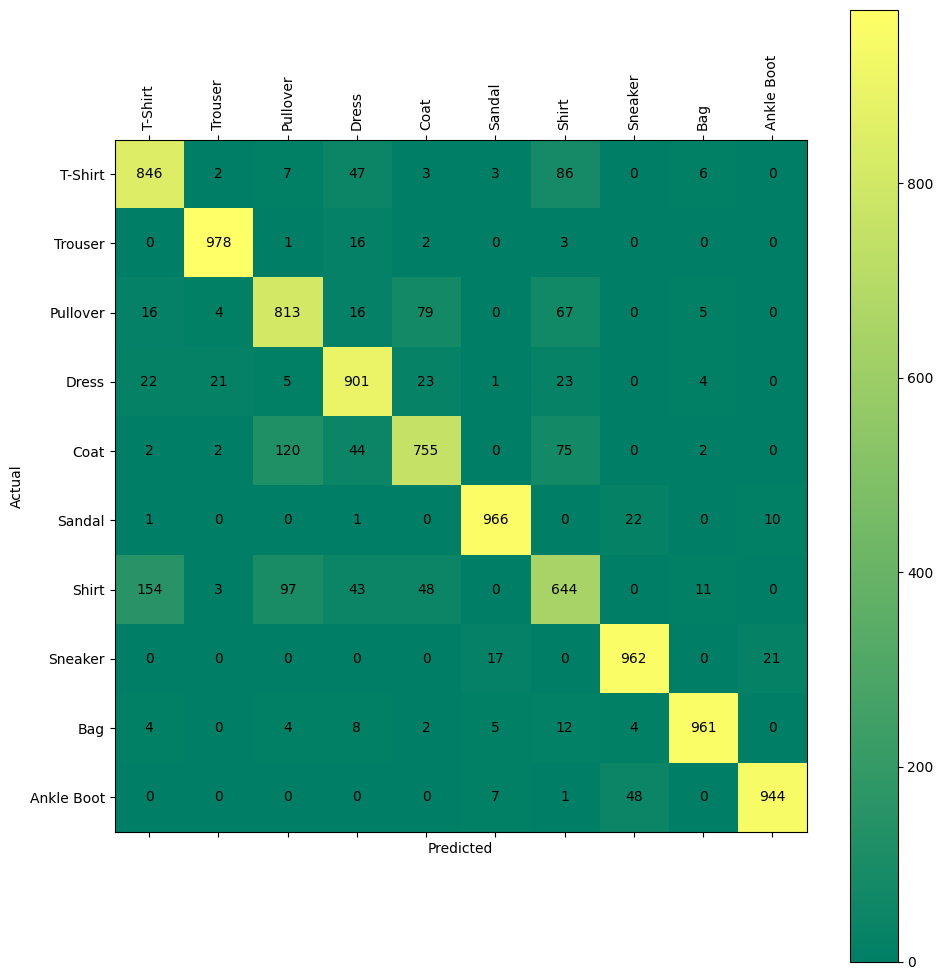

In [27]:
confusion_matrix = cm(actual_labels, predicted_labels)

pd.DataFrame(
    data=confusion_matrix,
    index=list(range(10)),
    columns=list(range(10))
).to_csv(os.path.join(models_output_folder_path, 'confusion_matrix.csv'), index=True)

plt.figure(num='Confusion Matrix', figsize=(10, 10))
plt.matshow(confusion_matrix, cmap='summer', fignum=0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(list(range(10)), [FashionMNIST.LABEL_MAP[label_idx] for label_idx in range(10)], rotation=90)
plt.yticks(list(range(10)), [FashionMNIST.LABEL_MAP[label_idx] for label_idx in range(10)])
for (i, j), value in np.ndenumerate(confusion_matrix):
    plt.text(j, i, value, ha='center', va='center')
plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(models_output_folder_path, 'confusion_matrix.png'), format='png')
plt.show()